# Simple CNN Inference for ActorDepthCNN

이 노트북은 Isaac Lab/Sim 종속성 없이 순수 PyTorch만 사용하여 ActorDepthCNN 모델을 로드하고 추론을 실행하는 방법을 보여줍니다.

## 주요 기능
- 학습된 모델 로딩
- Dict 형태의 observation 처리
- 다양한 시나리오별 테스트
- 실시간 추론 실행

## 모델 정보
- **ActorDepthCNN**: Proprioceptive + Depth 데이터 처리
- **Proprioceptive**: 51차원 (base_lin_vel, base_ang_vel, projected_gravity, base_rpy, velocity_commands, joint_pos, joint_vel, actions)
- **Depth**: 24×32 이미지
- **Actions**: 12개 관절 액션


In [1]:
# 필요한 라이브러리 import
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


## 1. 네트워크 클래스 정의

ActorDepthCNN 모델과 관련 클래스들을 정의합니다.


In [2]:
def get_activation(act_name):
    """Activation function factory"""
    if act_name == "elu":
        return nn.ELU()
    elif act_name == "selu":
        return nn.SELU()
    elif act_name == "relu":
        return nn.ReLU()
    elif act_name == "crelu":
        return nn.CReLU()
    elif act_name == "lrelu":
        return nn.LeakyReLU()
    elif act_name == "tanh":
        return nn.Tanh()
    elif act_name == "sigmoid":
        return nn.Sigmoid()
    else:
        print("invalid activation function!")
        return None


class DepthOnlyFCBackbone(nn.Module):
    """Depth image processing backbone"""
    def __init__(self, output_dim, hidden_dim, activation, num_frames=1):
        super().__init__()

        self.num_frames = num_frames
        self.output_dim = output_dim
        self.image_compression = nn.Sequential(
            # [1, 24, 32]
            nn.Conv2d(in_channels=self.num_frames, out_channels=16, kernel_size=5),
            # [16, 20, 28]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [16, 10, 14]
            activation,
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            # [32, 8, 12]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [32, 4, 6]
            activation,
            nn.Flatten(),
            
            nn.Linear(32 * 4 * 6, hidden_dim),
            activation,
            nn.Linear(hidden_dim, output_dim),
            activation
        )

    def forward(self, images: torch.Tensor):
        latent = self.image_compression(images.unsqueeze(1))
        return latent


In [3]:
class ActorDepthCNN(nn.Module):
    """Actor network with depth CNN"""
    def __init__(self, 
                 num_obs_proprio, 
                 obs_depth_shape, 
                 num_actions,
                 activation,
                 hidden_dims=[256, 256, 128], 
        ):
        super().__init__()

        self.prop_mlp = nn.Sequential(
            nn.Linear(num_obs_proprio, hidden_dims[0]),
            activation,
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            activation,
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            activation,
        )
        self.depth_backbone = DepthOnlyFCBackbone(
            output_dim=hidden_dims[2],
            hidden_dim=hidden_dims[1],
            activation=activation,
            num_frames=1,
        )

        self.action_head = nn.Linear(2 * hidden_dims[2], num_actions)

        self.num_obs_proprio = num_obs_proprio
        self.obs_depth_shape = obs_depth_shape
    
    def forward(self, x):
        prop_input = x[..., :self.num_obs_proprio]
        prop_latent = self.prop_mlp(prop_input)

        depth_input = x[..., self.num_obs_proprio:]
        ori_shape = depth_input.shape
        depth_input = depth_input.reshape(-1, *self.obs_depth_shape)
        depth_latent = self.depth_backbone(depth_input)

        actions = self.action_head(torch.cat((prop_latent, depth_latent), dim=-1))
        return actions


## 2. 유틸리티 함수 정의

모델 로딩, 추론 실행, observation 생성 등의 유틸리티 함수들을 정의합니다.


In [4]:
def load_policy(model_path):
    """
    Load actor network from model.pt checkpoint
    
    Args:
        model_path (str): Path to model.pt file
        
    Returns:
        ActorDepthCNN: Loaded actor network
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location='cpu')
    
    # Extract actor_critic from checkpoint
    actor_critic_state = checkpoint['model_state_dict']
    
    # Create actor network with same parameters as training
    actor = ActorDepthCNN(
        num_obs_proprio=51,
        obs_depth_shape=(24, 32),
        num_actions=12,
        activation=get_activation("elu"),
        hidden_dims=[512, 256, 128]
    )
    
    # Load actor weights
    actor_state_dict = {}
    for key, value in actor_critic_state.items():
        if key.startswith('actor.'):
            # Remove 'actor.' prefix
            new_key = key[6:]  # Remove 'actor.' prefix
            actor_state_dict[new_key] = value
    
    actor.load_state_dict(actor_state_dict)
    actor.eval()
    
    return actor


In [5]:
def infer(observation_dict, actor_network):
    """
    Run inference on observation dict
    
    Args:
        observation_dict (dict): Dictionary containing 'proprio' and 'depth' keys
            - 'proprio': torch.Tensor of shape (51,) - proprioceptive observations
            - 'depth': torch.Tensor of shape (24, 32) - depth image
        actor_network (ActorDepthCNN): Loaded actor network
        
    Returns:
        torch.Tensor: Action tensor of shape (12,) - joint actions
    """
    with torch.no_grad():
        # Extract observations
        proprio = observation_dict['proprio']  # Shape: (51,)
        depth = observation_dict['depth']      # Shape: (24, 32)
        
        # Ensure tensors are float32 and have batch dimension
        if proprio.dim() == 1:
            proprio = proprio.unsqueeze(0)  # Shape: (1, 51)
        if depth.dim() == 2:
            depth = depth.unsqueeze(0)      # Shape: (1, 24, 32)
            
        # Concatenate proprio and depth (flatten depth)
        depth_flat = depth.view(depth.shape[0], -1)  # Shape: (1, 768)
        combined_obs = torch.cat([proprio, depth_flat], dim=-1)  # Shape: (1, 819)
        
        # Run inference
        actions = actor_network(combined_obs)  # Shape: (1, 12)
        
        # Remove batch dimension
        return actions.squeeze(0)  # Shape: (12,)


In [6]:
def create_proprio_observation(
    base_lin_vel=None,
    base_ang_vel=None, 
    projected_gravity=None,
    base_rpy=None,
    velocity_commands=None,
    joint_pos=None,
    joint_vel=None,
    actions=None
):
    """
    Create proprioceptive observation tensor
    
    Args:
        base_lin_vel (torch.Tensor, optional): Base linear velocity (3,). Default: zeros
        base_ang_vel (torch.Tensor, optional): Base angular velocity (3,). Default: zeros
        projected_gravity (torch.Tensor, optional): Projected gravity vector (3,). Default: [0, 0, -1]
        base_rpy (torch.Tensor, optional): Base roll-pitch-yaw (3,). Default: zeros
        velocity_commands (torch.Tensor, optional): Velocity commands (3,). Default: zeros
        joint_pos (torch.Tensor, optional): Joint positions (12,). Default: zeros
        joint_vel (torch.Tensor, optional): Joint velocities (12,). Default: zeros
        actions (torch.Tensor, optional): Previous actions (12,). Default: zeros
        
    Returns:
        torch.Tensor: Concatenated proprioceptive observation (51,)
    """
    # Default values
    if base_lin_vel is None:
        base_lin_vel = torch.zeros(3)
    if base_ang_vel is None:
        base_ang_vel = torch.zeros(3)
    if projected_gravity is None:
        projected_gravity = torch.tensor([0.0, 0.0, -1.0])
    if base_rpy is None:
        base_rpy = torch.zeros(3)
    if velocity_commands is None:
        velocity_commands = torch.zeros(3)
    if joint_pos is None:
        joint_pos = torch.zeros(12)
    if joint_vel is None:
        joint_vel = torch.zeros(12)
    if actions is None:
        actions = torch.zeros(12)
    
    # Concatenate all proprioceptive data
    proprio = torch.cat([
        base_lin_vel,      # 3
        base_ang_vel,      # 3
        projected_gravity, # 3
        base_rpy,          # 3
        velocity_commands, # 3
        joint_pos,         # 12
        joint_vel,         # 12
        actions            # 12
    ])  # Total: 51
    
    return proprio


In [7]:
def create_realistic_observation():
    """
    Create more realistic observation for testing
    
    Returns:
        dict: Realistic observation dictionary
    """
    # Create realistic proprioceptive data
    proprio = create_proprio_observation(
        base_lin_vel=torch.tensor([0.5, 0.0, 0.0]),  # Moving forward
        base_ang_vel=torch.tensor([0.0, 0.0, 0.1]),  # Slight yaw rotation
        projected_gravity=torch.tensor([0.0, 0.0, -1.0]),  # Gravity pointing down
        base_rpy=torch.tensor([0.05, 0.02, 0.1]),  # Small roll/pitch/yaw
        velocity_commands=torch.tensor([0.5, 0.0, 0.0]),  # Forward command
        joint_pos=torch.tensor([0.1, -0.1, 0.8, 0.8, 1.0, 1.0, -1.5, -1.5, -1.5, -1.5, 0.0, 0.0]),  # Typical joint positions
        joint_vel=torch.randn(12) * 0.1,  # Small joint velocities
        actions=torch.randn(12) * 0.1  # Previous actions
    )
    
    # Create depth image (closer objects = smaller values)
    depth = torch.rand(24, 32) * 2.0 + 0.3  # Range: 0.3 to 2.3 meters
    
    return {
        'proprio': proprio,
        'depth': depth
    }


def create_example_observation():
    """
    Create example observation for testing
    
    Returns:
        dict: Example observation dictionary
    """
    # Create random example data
    proprio = torch.randn(51)  # Random proprioceptive data
    depth = torch.randn(24, 32)  # Random depth image
    
    return {
        'proprio': proprio,
        'depth': depth
    }


## 3. 모델 로딩

학습된 모델을 로드합니다. 모델 경로를 변경하여 다른 체크포인트를 사용할 수 있습니다.


In [8]:
# 모델 경로 설정 (필요에 따라 변경)
model_path = '/home/syaro/DeepL_WS/navila/legged-loco/logs/rsl_rl/go1_vision_rough/2025-10-25_20-42-24_cnn_nohis/model_1500.pt'

# 모델 로딩
print("Loading trained model...")
actor = load_policy(model_path)
print("Model loaded successfully!")
print(f"Model device: {next(actor.parameters()).device}")
print(f"Model parameters: {sum(p.numel() for p in actor.parameters()):,}")


Loading trained model...
Model loaded successfully!
Model device: cpu
Model parameters: 428,748


## 4. 테스트 및 실험

다양한 시나리오로 모델을 테스트해보겠습니다.


In [9]:
# 테스트 1: 현실적인 observation
print("=== Test 1: Realistic observation ===")
obs1 = create_realistic_observation()
action1 = infer(obs1, actor)
print(f"Action shape: {action1.shape}")
print(f"Action values: {action1}")
print(f"Action range: [{action1.min():.3f}, {action1.max():.3f}]")
print(f"Action mean: {action1.mean():.3f}")
print(f"Action std: {action1.std():.3f}")


=== Test 1: Realistic observation ===
Action shape: torch.Size([12])
Action values: tensor([ 1.7896, -1.1598,  0.2564,  1.5141,  0.5039,  3.1340, -3.4605, -3.1182,
        -4.9126, -2.3449,  1.6167,  2.4308])
Action range: [-4.913, 3.134]
Action mean: -0.313
Action std: 2.623


In [57]:
# 테스트 2: 정지 명령
print("=== Test 2: Stop command ===")
obs2 = create_realistic_observation()
obs2['proprio'] = create_proprio_observation(
    base_lin_vel=torch.tensor([0.0, 0.0, 0.0]),
    velocity_commands=torch.tensor([0.0, 0.0, 0.0])
)
action2 = infer(obs2, actor)
print(f"Stop action: {action2}")
print(f"Action range: [{action2.min():.3f}, {action2.max():.3f}]")


=== Test 2: Stop command ===
Stop action: tensor([ 0.4440,  0.2791, -0.8581,  0.5404, -1.7508, -0.0768, -1.9886, -1.5288,
         0.0379,  2.2232,  1.5437, -0.2675])
Action range: [-1.989, 2.223]


In [58]:
# 테스트 3: 빠른 전진 명령
print("=== Test 3: Fast forward command ===")
obs3 = create_realistic_observation()
obs3['proprio'] = create_proprio_observation(
    base_lin_vel=torch.tensor([1.0, 0.0, 0.0]),
    velocity_commands=torch.tensor([1.0, 0.0, 0.0])
)
action3 = infer(obs3, actor)
print(f"Fast forward action: {action3}")
print(f"Action range: [{action3.min():.3f}, {action3.max():.3f}]")


=== Test 3: Fast forward command ===
Fast forward action: tensor([ 0.3251,  0.0077, -1.1925,  0.8949, -1.5029,  0.0743, -0.4297, -0.8319,
        -0.2316,  2.1834,  0.3747, -0.7432])
Action range: [-1.503, 2.183]


In [59]:
# 테스트 4: 좌회전 명령
print("=== Test 4: Turn left command ===")
obs4 = create_realistic_observation()
obs4['proprio'] = create_proprio_observation(
    base_lin_vel=torch.tensor([0.0, 0.0, 0.0]),
    velocity_commands=torch.tensor([0.0, 0.0, 1.0])
)
action4 = infer(obs4, actor)
print(f"Turn left action: {action4}")
print(f"Action range: [{action4.min():.3f}, {action4.max():.3f}]")


=== Test 4: Turn left command ===
Turn left action: tensor([-0.1125, -0.4860, -0.2473,  1.3895, -2.2889, -0.0479, -2.5451, -1.6133,
        -0.0983,  3.2105,  1.8773, -0.5131])
Action range: [-2.545, 3.210]


## 5. 시각화 및 분석

액션 패턴을 시각화하고 분석해보겠습니다.


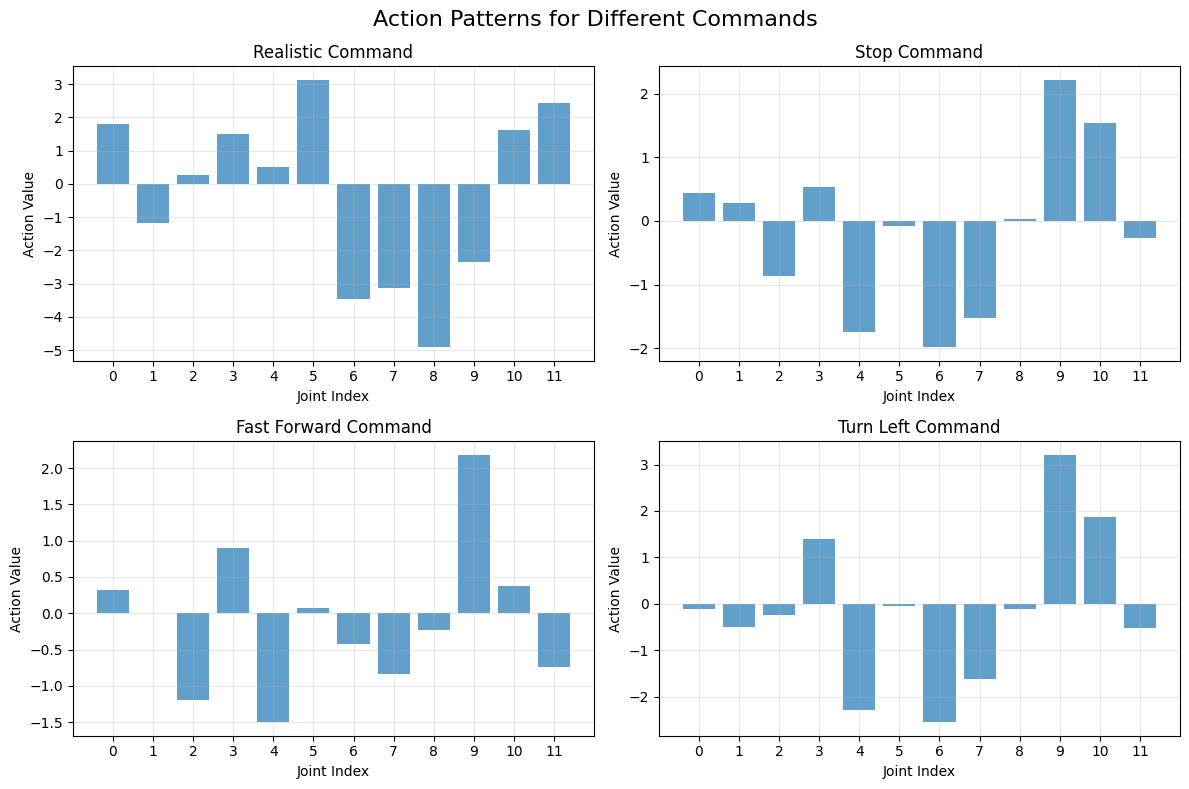

In [ ]:
# 로봇 다리 시각화 (2중 진자 모델)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle, FancyBboxPatch
import matplotlib.animation as animation

def draw_robot_leg(ax, joint_angles, leg_id, color='blue', scale=1.0):
    """
    로봇 다리를 2중 진자로 그리기
    
    Args:
        ax: matplotlib axes
        joint_angles: [hip, thigh, calf] 각도 (라디안)
        leg_id: 다리 ID (0: FL, 1: FR, 2: RL, 3: RR)
        color: 다리 색상
        scale: 크기 스케일
    """
    # 다리 위치 (로봇 기준)
    leg_positions = {
        0: (0.2, 0.15),   # FL (Front Left)
        1: (0.2, -0.15),  # FR (Front Right) 
        2: (-0.2, 0.15),  # RL (Rear Left)
        3: (-0.2, -0.15)  # RR (Rear Right)
    }
    
    leg_names = ['FL', 'FR', 'RL', 'RR']
    base_x, base_y = leg_positions[leg_id]
    
    # 관절 길이 (미터)
    thigh_length = 0.2 * scale
    calf_length = 0.2 * scale
    
    # 관절 각도
    hip_angle, thigh_angle, calf_angle = joint_angles
    
    # 다리 방향 (좌우 대칭)
    leg_direction = 1 if leg_id in [0, 2] else -1  # Left legs vs Right legs
    
    # Hip joint position
    hip_x = base_x
    hip_y = base_y
    
    # Thigh joint position
    thigh_x = hip_x + leg_direction * thigh_length * np.sin(thigh_angle)
    thigh_y = hip_y - thigh_length * np.cos(thigh_angle)
    
    # Calf joint position (foot)
    calf_x = thigh_x + leg_direction * calf_length * np.sin(thigh_angle + calf_angle)
    calf_y = thigh_y - calf_length * np.cos(thigh_angle + calf_angle)
    
    # 다리 그리기
    ax.plot([hip_x, thigh_x], [hip_y, thigh_y], color=color, linewidth=4, alpha=0.8)
    ax.plot([thigh_x, calf_x], [thigh_y, calf_y], color=color, linewidth=3, alpha=0.8)
    
    # 관절 그리기
    ax.add_patch(Circle((hip_x, hip_y), 0.02, color='black', alpha=0.7))
    ax.add_patch(Circle((thigh_x, thigh_y), 0.015, color='black', alpha=0.7))
    ax.add_patch(Circle((calf_x, calf_y), 0.01, color='red', alpha=0.7))  # 발
    
    # 다리 이름 표시
    ax.text(base_x + 0.05, base_y, leg_names[leg_id], fontsize=10, fontweight='bold')

def visualize_robot_actions(actions_list, titles_list):
    """
    여러 액션을 로봇 다리로 시각화
    
    Args:
        actions_list: 액션 리스트 (각 액션은 12차원)
        titles_list: 각 액션의 제목 리스트
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Robot Leg Configurations for Different Commands', fontsize=16)
    
    colors = ['blue', 'green', 'red', 'orange']
    
    for i, (actions, title) in enumerate(zip(actions_list, titles_list)):
        ax = axes[i//2, i%2]
        
        # 로봇 몸체 그리기
        body = FancyBboxPatch((-0.25, -0.2), 0.5, 0.4, 
                             boxstyle="round,pad=0.02", 
                             facecolor='lightgray', edgecolor='black', linewidth=2)
        ax.add_patch(body)
        
        # 각 다리 그리기 (FL, FR, RL, RR 순서)
        for leg_id in range(4):
            # 액션에서 해당 다리의 관절 각도 추출
            leg_actions = actions[leg_id*3:(leg_id+1)*3]  # 각 다리당 3개 관절
            draw_robot_leg(ax, leg_actions, leg_id, color=colors[i], scale=1.0)
        
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(-0.5, 0.5)
        ax.set_aspect('equal')
        ax.set_title(f'{title} Command', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
    
    plt.tight_layout()
    plt.show()

# 액션을 로봇 다리로 시각화
actions = [action1, action2, action3, action4]
titles = ['Realistic', 'Stop', 'Fast Forward', 'Turn Left']

visualize_robot_actions(actions, titles)


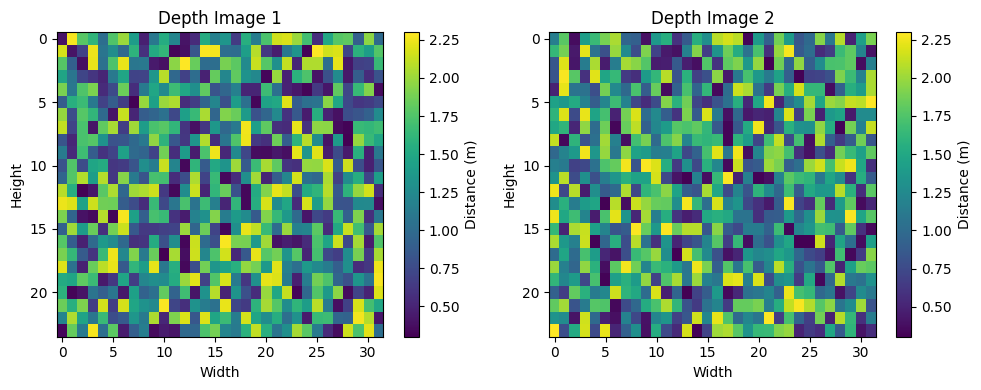

In [64]:
# Depth 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 첫 번째 depth 이미지
depth_img1 = obs1['depth'].numpy()
im1 = axes[0].imshow(depth_img1, cmap='viridis', aspect='auto')
axes[0].set_title('Depth Image 1')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Height')
plt.colorbar(im1, ax=axes[0], label='Distance (m)')

# 두 번째 depth 이미지
depth_img2 = obs2['depth'].numpy()
im2 = axes[1].imshow(depth_img2, cmap='viridis', aspect='auto')
axes[1].set_title('Depth Image 2')
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Height')
plt.colorbar(im2, ax=axes[1], label='Distance (m)')

plt.tight_layout()
plt.show()


## 6. 사용법 가이드

### 기본 사용법

```python
# 1. 모델 로드
actor = load_policy('path/to/your/model.pt')

# 2. Observation 준비
observation = {
    'proprio': create_proprio_observation(
        base_lin_vel=torch.tensor([0.5, 0.0, 0.0]),
        velocity_commands=torch.tensor([0.5, 0.0, 0.0])
    ),
    'depth': your_depth_tensor  # Shape: (24, 32)
}

# 3. 추론 실행
action = infer(observation, actor)  # Shape: (12,)
```

### Proprioceptive Observation 구성 요소

- **base_lin_vel** (3,): 로봇 베이스 선형 속도 [x, y, z]
- **base_ang_vel** (3,): 로봇 베이스 각속도 [roll, pitch, yaw]
- **projected_gravity** (3,): 중력 벡터 (보통 [0, 0, -1])
- **base_rpy** (3,): 롤-피치-야우 각도
- **velocity_commands** (3,): 속도 명령 [vx, vy, ωz]
- **joint_pos** (12,): 관절 위치 (12개 관절)
- **joint_vel** (12,): 관절 속도 (12개 관절)
- **actions** (12,): 이전 액션 (12개 관절)

### Depth 이미지

- **크기**: 24×32 픽셀
- **범위**: 0.3m ~ 2.3m (일반적으로)
- **형식**: torch.Tensor, 값이 작을수록 가까운 물체


## 7. 커스텀 실험

자신만의 실험을 위한 셀입니다. 아래 코드를 수정하여 다양한 시나리오를 테스트해보세요.


In [ ]:
# 커스텀 실험 셀 - 자유롭게 수정하여 사용하세요

# 예시: 특정 관절 위치로 테스트
custom_obs = create_realistic_observation()
custom_obs['proprio'] = create_proprio_observation(
    base_lin_vel=torch.tensor([0.3, 0.0, 0.0]),  # 천천히 전진
    velocity_commands=torch.tensor([0.3, 0.0, 0.0]),  # 천천히 전진 명령
    joint_pos=torch.tensor([0.0, 0.0, 0.5, 0.5, 0.5, 0.5, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0])  # 특정 관절 위치
)

custom_action = infer(custom_obs, actor)
print(f"Custom experiment action: {custom_action}")
print(f"Action range: [{custom_action.min():.3f}, {custom_action.max():.3f}]")

# 여러 번 실행하여 일관성 확인
print("\nConsistency test (5 runs):")
for i in range(5):
    test_obs = create_realistic_observation()
    test_action = infer(test_obs, actor)
    print(f"Run {i+1}: mean={test_action.mean():.3f}, std={test_action.std():.3f}")
